# GPyTorch Regression Tutorial

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function

\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}

with 100 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
def f(x, noise=1e-1):
    #y = torch.sin(x * (2 * math.pi))
    y = torch.sin(x * (2 * math.pi)) ** 3
    y = y + torch.randn_like(y) * noise
    return y

N = 100
torch.manual_seed(0)
train_x = torch.linspace(-1, 1, N)
train_y = f(train_x)

def f(x, noise=1e-1):
    # Styblinski-Tang
    y = (x.pow(2) - 16*x.pow(2) + 5*x).sum(-1) / 2
    y = y + torch.randn_like(y) * noise
    return y

train_x = torch.randn(1000, 10)
train_y = f(train_x)

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        
        #assert 1 <= train_x.ndim <= 2
        #init_theta = (train_x[1:] - train_x[:-1]).norm(2, dim=-1).median()
        #self.covar_module = gpytorch.kernels.ScaleKernel(
        #                        gpytorch.kernels.RBFKernel().initialize(lengthscale=init_theta)
        #)
        self.covar_module = gpytorch.kernels.RBFKernel()
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model = model.cuda()
train_x = train_x.cuda()
train_y = train_y.cuda()


model = model.float()
train_x = train_x.float()
train_y = train_y.float()


training_iter = 100
gpytorch.settings.cache = []
true_lengthscales = [model.covar_module.lengthscale.item()]
true_noises = [model.likelihood.noise.item()]

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.skip_logdet_forward(), \
    gpytorch.settings.cg_tolerance(1e-5), \
    gpytorch.settings.max_preconditioner_size(0), \
    gpytorch.settings.max_cg_iterations(len(train_y)), \
    gpytorch.settings.deterministic_probes(), \
    gpytorch.settings.num_trace_samples(10), \
    gpytorch.settings.max_cholesky_size(1) \
:
    
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

        true_lengthscales.append(model.covar_module.lengthscale.item())
        true_noises.append(model.likelihood.noise.item())
        
true_iters_used = list(gpytorch.settings.cache)

Tolerance after 11 iterations: 1.4103665080256178e-06
Iter 1/100 - Loss: 1.104   lengthscale: 0.693   noise: 0.693
Tolerance after 10 iterations: 2.037097146967426e-06
Iter 2/100 - Loss: 1.108   lengthscale: 0.644   noise: 0.644
Tolerance after 11 iterations: 4.875148079008795e-06
Iter 3/100 - Loss: 1.109   lengthscale: 0.599   noise: 0.598
Tolerance after 11 iterations: 2.7051607958128443e-06
Iter 4/100 - Loss: 1.105   lengthscale: 0.556   noise: 0.554
Tolerance after 12 iterations: 2.0656043488997966e-06
Iter 5/100 - Loss: 1.096   lengthscale: 0.516   noise: 0.513
Tolerance after 14 iterations: 1.5046060752865742e-06
Iter 6/100 - Loss: 1.082   lengthscale: 0.479   noise: 0.474
Tolerance after 14 iterations: 1.4998032611401868e-06
Iter 7/100 - Loss: 1.064   lengthscale: 0.443   noise: 0.437
Tolerance after 16 iterations: 5.958949259365909e-06
Iter 8/100 - Loss: 1.047   lengthscale: 0.408   noise: 0.402
Tolerance after 15 iterations: 1.5316882127081044e-06
Iter 9/100 - Loss: 1.034   le

In [20]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model = model.cuda()
train_x = train_x.cuda()
train_y = train_y.cuda()


model = model.float()
train_x = train_x.float()
train_y = train_y.float()


training_iter = 100
gpytorch.settings.cache = []
lengthscales = [model.covar_module.lengthscale.item()]
noises = [model.likelihood.noise.item()]

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.SGD([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.skip_logdet_forward(), \
    gpytorch.settings.cg_tolerance(1e-5), \
    gpytorch.settings.ir_solve(), \
    gpytorch.settings.max_preconditioner_size(0), \
    gpytorch.settings.max_cg_iterations(len(train_y)), \
    gpytorch.settings.deterministic_probes(), \
    gpytorch.settings.num_trace_samples(10), \
    gpytorch.settings.max_cholesky_size(1) \
:
    
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

        lengthscales.append(model.covar_module.lengthscale.item())
        noises.append(model.likelihood.noise.item())
        
iters_used = list(gpytorch.settings.cache)

/mnt/storage1/Documents/repos/gpytorch/gpytorch/functions/_inv_quad_log_det.py:75: UserWarning: Deterministic probes will currently work only if you aren't training multiple independent models simultaneously.
  warnings.warn(


Tolerance after 11 iterations: 1.1597074944802443e-06
Iter 1/100 - Loss: 1.104   lengthscale: 0.693   noise: 0.693
Tolerance after 5 iterations: 0.005674044135957956
Iter 2/100 - Loss: 1.107   lengthscale: 0.690   noise: 0.682
Tolerance after 5 iterations: 0.005595462862402201
Iter 3/100 - Loss: 1.109   lengthscale: 0.687   noise: 0.671
Tolerance after 5 iterations: 0.005571203306317329
Iter 4/100 - Loss: 1.112   lengthscale: 0.684   noise: 0.660
Tolerance after 5 iterations: 0.005517615005373955
Iter 5/100 - Loss: 1.114   lengthscale: 0.681   noise: 0.649
Tolerance after 5 iterations: 0.005422786809504032
Iter 6/100 - Loss: 1.116   lengthscale: 0.677   noise: 0.638
Tolerance after 5 iterations: 0.005270074121654034
Iter 7/100 - Loss: 1.119   lengthscale: 0.674   noise: 0.627
Tolerance after 5 iterations: 0.005061013158410788
Iter 8/100 - Loss: 1.121   lengthscale: 0.670   noise: 0.617
Tolerance after 5 iterations: 0.004991516005247831
Iter 9/100 - Loss: 1.123   lengthscale: 0.667   no

In [14]:
params = torch.stack([torch.as_tensor(lengthscales), torch.as_tensor(noises)], dim=-1)
true_params = torch.stack([torch.as_tensor(true_lengthscales), torch.as_tensor(true_noises)], dim=-1)

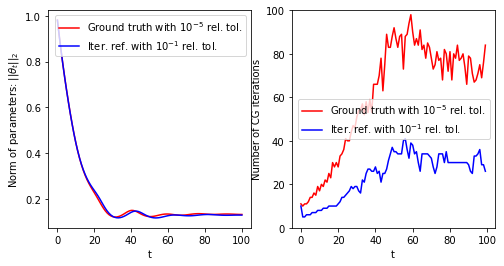

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

axes[0].plot(true_params.norm(2, dim=-1), 'r', label=r"Ground truth with $10^{-5}$ rel. tol.")
axes[0].plot(params.norm(2, dim=-1), 'b', label=r"Iter. ref. with $10^{-1}$ rel. tol.")
axes[0].set(xlabel="t", ylabel=r"Norm of parameters: $||\theta_t||_2$")
axes[0].legend()


axes[1].plot(true_iters_used, 'r', label=r"Ground truth with $10^{-5}$ rel. tol.")
axes[1].plot(iters_used, 'b', label=r"Iter. ref. with $10^{-1}$ rel. tol.")
axes[1].set(xlabel="t", ylabel=r"Number of CG iterations", ylim=[0, 100])
axes[1].legend()

In [16]:
fig.savefig("mle-true-low-tol.pdf", bbox_inches="tight")

In [25]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model = model.cuda()
train_x = train_x.cuda()
train_y = train_y.cuda()


model = model.float()
train_x = train_x.float()
train_y = train_y.float()


training_iter = 100
gpytorch.settings.cache = []
true_lengthscales = [model.covar_module.lengthscale.item()]
true_noises = [model.likelihood.noise.item()]

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.skip_logdet_forward(), \
    gpytorch.settings.cg_tolerance(1e-1), \
    gpytorch.settings.max_preconditioner_size(0), \
    gpytorch.settings.max_cg_iterations(len(train_y)), \
    gpytorch.settings.deterministic_probes(), \
    gpytorch.settings.num_trace_samples(10), \
    gpytorch.settings.max_cholesky_size(1) \
:
    
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

        true_lengthscales.append(model.covar_module.lengthscale.item())
        true_noises.append(model.likelihood.noise.item())
        
true_iters_used = list(gpytorch.settings.cache)

Tolerance after 5 iterations: 0.008455730974674225
Iter 1/100 - Loss: 1.104   lengthscale: 0.693   noise: 0.693
Tolerance after 5 iterations: 0.015718189999461174
Iter 2/100 - Loss: 1.108   lengthscale: 0.644   noise: 0.644
Tolerance after 5 iterations: 0.026127349585294724
Iter 3/100 - Loss: 1.108   lengthscale: 0.599   noise: 0.598
Tolerance after 5 iterations: 0.0455063059926033
Iter 4/100 - Loss: 1.104   lengthscale: 0.556   noise: 0.554
Tolerance after 6 iterations: 0.008522242307662964
Iter 5/100 - Loss: 1.096   lengthscale: 0.516   noise: 0.513
Tolerance after 6 iterations: 0.017869552597403526
Iter 6/100 - Loss: 1.081   lengthscale: 0.478   noise: 0.474
Tolerance after 7 iterations: 0.005710175260901451
Iter 7/100 - Loss: 1.064   lengthscale: 0.442   noise: 0.437
Tolerance after 7 iterations: 0.00690868403762579
Iter 8/100 - Loss: 1.047   lengthscale: 0.407   noise: 0.402
Tolerance after 7 iterations: 0.01470586284995079
Iter 9/100 - Loss: 1.033   lengthscale: 0.375   noise: 0.

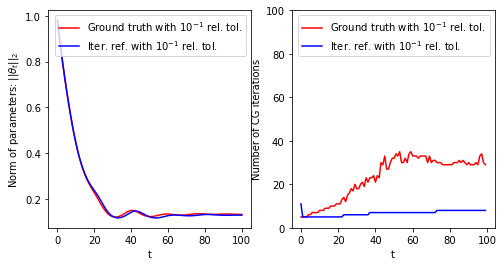

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

axes[0].plot(true_params.norm(2, dim=-1), 'r', label=r"Ground truth with $10^{-1}$ rel. tol.")
axes[0].plot(params.norm(2, dim=-1), 'b', label=r"Iter. ref. with $10^{-1}$ rel. tol.")
axes[0].set(xlabel="t", ylabel=r"Norm of parameters: $||\theta_t||_2$")
axes[0].legend()


axes[1].plot(true_iters_used, 'r', label=r"Ground truth with $10^{-1}$ rel. tol.")
axes[1].plot(iters_used, 'b', label=r"Iter. ref. with $10^{-1}$ rel. tol.")
axes[1].set(xlabel="t", ylabel=r"Number of CG iterations", ylim=[0, 100])
axes[1].legend()

In [19]:
fig.savefig("mle-true-high-tol.pdf", bbox_inches="tight")

In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 10, device=train_x.device)
    test_x = torch.linspace(-2, 2, 100, device=train_x.device)
    observed_pred = likelihood(model(test_x))

Tolerance after 38 iterations: 0.0073307272978127


In [8]:
(observed_pred.mean - f(test_x)).pow(2).mean()

tensor(0.2070, device='cuda:0')

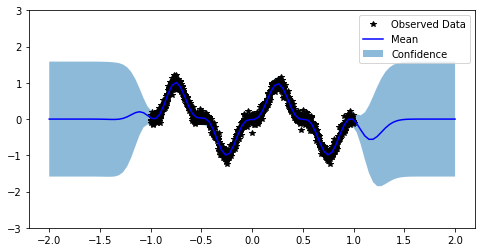

In [9]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])